In [4]:
import pandas as pd
import numpy as np
from datetime import datetime

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Предварительный этап формирования фич

In [5]:
links = pd.read_csv('C:\\Users\\Alexandr\\links.csv')
movies = pd.read_csv('C:\\Users\\Alexandr\\movies.csv')
ratings = pd.read_csv('C:\\Users\\Alexandr\\ratings.csv')
tags = pd.read_csv('C:\\Users\\Alexandr\\tags.csv')
genome_tags = pd.read_csv('C:\\Users\\Alexandr\\genome-tags.csv') 
genome_scores = pd.read_csv('C:\\Users\\Alexandr\\genome-scores.csv')                           

In [6]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
links.movieId.count()

58098

In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
num_genres_on_movie = [len(g.split('|')) for g in movies.genres.values] # кол-во жанров на фильм

(array([2.793e+03, 3.039e+03, 2.115e+03, 8.520e+02, 2.610e+02, 5.000e+01,
        1.100e+01, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

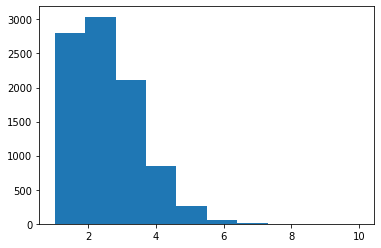

In [10]:
plt.hist(num_genres_on_movie)

In [11]:
np.mean(num_genres_on_movie) # среднее значение жанкров 

2.2290410958904108

In [12]:
np.median(num_genres_on_movie) # медианное значение жанров

2.0

In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


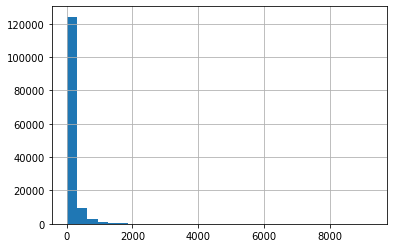

In [14]:
ratings.groupby('userId').movieId.count().hist(bins=30) # сколько фильмов оцеливал каждый юзер

In [15]:
ratings.loc[ratings['userId'] == 1].count()

userId       175
movieId      175
rating       175
timestamp    175
dtype: int64

In [16]:
tags.head(10)

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
5,14,318,justice,1442615192
6,14,480,Dinosaurs,1443148563
7,14,593,psychothriller,1444014286
8,14,1682,philosophy,1442615158
9,14,1682,surveillance,1442615167


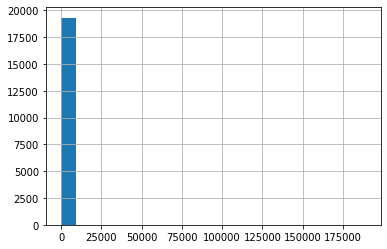

In [17]:
tags.groupby('userId').tag.count().hist(bins=20)

In [18]:
tags.groupby('userId').tag.count().median() # медианное значение кол-ва проставленных тегов на пользователя

4.0

In [19]:
tags.groupby('userId').tag.count().mean() # среднее значение кол-ва проставленных тегов на пользователя

57.38582147477361

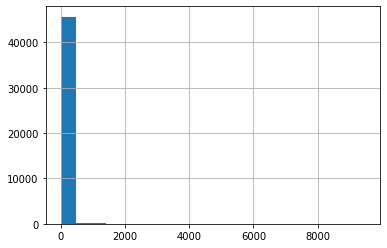

In [20]:
tags.groupby('movieId').tag.count().hist(bins=20) # количество тегов на фильм

In [21]:
tags.groupby('movieId').tag.count().mean() # среднее значение кол-ва проставленных тегов на фильм

24.118244492290295

In [22]:
tags.groupby('movieId').tag.count().median() # медианное значение кол-ва проставленных тегов на фильм

5.0

In [23]:
year_month = []

for t in tqdm_notebook(tags.timestamp.values):
    d = datetime.fromtimestamp(t)
    year_month.append(str(d.year) + '-' + str(d.month))

C:\Users\Alexandr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
tags['year_month'] = np.array(year_month)

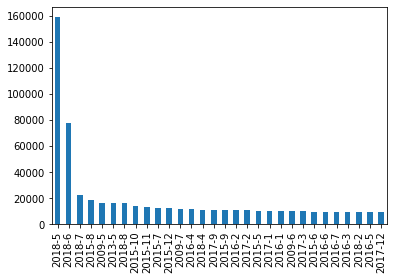

In [25]:
tags.year_month.value_counts()[:30].plot.bar()

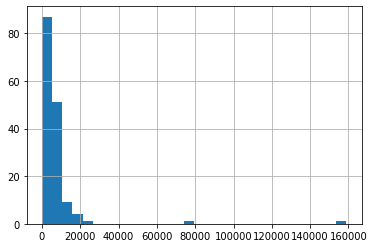

In [26]:
tags.groupby('year_month').tag.count().hist(bins=30)

In [27]:
tags.groupby('year_month').tag.count().mean()  # среднее значение кол-ва тегов за все время

7201.175324675325

In [28]:
tags.groupby('year_month').tag.count().median() # медианное значение кол-ва тегов за все время

4831.5

In [29]:
genome_tags.head(20) 

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
5,6,1950s
6,7,1960s
7,8,1970s
8,9,1980s
9,10,19th century


In [30]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000


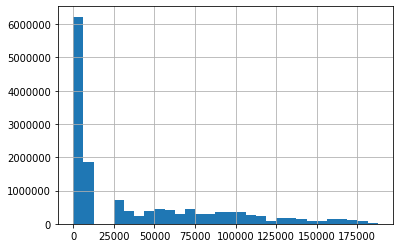

In [31]:
genome_scores.movieId.hist(bins=30)

# Этап обучения модели

In [32]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [33]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [34]:
movie_genres = [change_string(g) for g in movies.genres.values]

In [35]:
movie_genres[:10]

['Adventure Animation Children Comedy Fantasy',
 'Adventure Children Fantasy',
 'Comedy Romance',
 'Comedy Drama Romance',
 'Comedy',
 'Action Crime Thriller',
 'Comedy Romance',
 'Adventure Children',
 'Action',
 'Action Adventure Thriller']

In [36]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(movie_genres) # создаем матрицу весов

In [37]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts) # создаем матрицу весов tfidf

In [38]:
neigh = NearestNeighbors(n_neighbors=7, n_jobs=-1, metric='euclidean') 
neigh.fit(X_train_tfidf)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=-1, n_neighbors=7, p=2, radius=1.0)

In [39]:
test = change_string("Adventure|Comedy|Fantasy|Crime")

predict = count_vect.transform([test])
X_tfidf2 = tfidf_transformer.transform(predict)

res = neigh.kneighbors(X_tfidf2, return_distance=True)

In [40]:
res

(array([[0.42697878, 0.53455477, 0.53455477, 0.53455477, 0.53455477,
         0.53455477, 0.53455477]]),
 array([[6982, 3819, 7700,  912, 3611, 6927, 3815]], dtype=int64))

In [41]:
movies.iloc[res[1][0]]

,movieId,title,genres
6982,60074,Hancock (2008),Action|Adventure|Comedy|Crime|Fantasy
3819,4911,Jabberwocky (1977),Adventure|Comedy|Fantasy
7700,82854,Gulliver's Travels (2010),Adventure|Comedy|Fantasy
912,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
3611,4591,Erik the Viking (1989),Adventure|Comedy|Fantasy
6927,58972,Nim's Island (2008),Adventure|Comedy|Fantasy
3815,4899,Black Knight (2001),Adventure|Comedy|Fantasy


In [42]:
predict.toarray()[0:6]

array([[0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

In [60]:
mean_squared_error(X_train_tfidf, res[0]) # в функцию скармливаем таргет и наш результат предсказания

ValueError: Found input variables with inconsistent numbers of samples: [9125, 1]

# Обучение на тэге

In [48]:
tags.head(10)

,userId,movieId,tag,timestamp,year_month
0,14,110,epic,1443148538,2015-9
1,14,110,Medieval,1443148532,2015-9
2,14,260,sci-fi,1442169410,2015-9
3,14,260,space action,1442169421,2015-9
4,14,318,imdb top 250,1442615195,2015-9
5,14,318,justice,1442615192,2015-9
6,14,480,Dinosaurs,1443148563,2015-9
7,14,593,psychothriller,1444014286,2015-10
8,14,1682,philosophy,1442615158,2015-9
9,14,1682,surveillance,1442615167,2015-9


In [53]:
print(tags.tag.isnull().sum()) # в данных присутствовали Nan
tags_rez = tags.dropna() # удаляем Nan

16


In [54]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(list(tags_rez.tag.values)) # создаем матрицу весов

In [55]:
tfidf_transformer_rez = TfidfTransformer()
X_train_tfidf_rez = tfidf_transformer_rez.fit_transform(X_train_counts)

In [56]:
neigh_rez = NearestNeighbors(n_neighbors=7, n_jobs=-1, metric='euclidean') 
neigh_rez.fit(X_train_tfidf_rez)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=-1, n_neighbors=7, p=2, radius=1.0)

In [57]:
test_rez = change_string("Dinosaurs")

predict_rez = count_vect.transform([test_rez])
X_tfidf2_rez = tfidf_transformer_rez.transform(predict_rez)

rez = neigh_rez.kneighbors(X_tfidf2_rez, return_distance=True)

In [58]:
rez

(array([[0., 0., 0., 0., 0., 0., 0.]]),
 array([[ 621306,  125023,  558115,  963125,  828482,  563673, 1104239]],
       dtype=int64))

In [59]:
tags.iloc[rez[1][0]]

,userId,movieId,tag,timestamp,year_month
621306,121284,38886,teenagers,1254542125,2009-10
125023,40660,546,dinosaurs,1187878407,2007-8
558115,103013,63992,based on a book,1285320853,2010-9
963125,234914,115122,mockumentary,1492625583,2017-4
828482,188307,4447,Harvard Law school,1445400822,2015-10
563673,103013,110779,small town,1398493835,2014-4
1104239,282342,116797,England,1529534495,2018-6
